<a href="https://colab.research.google.com/github/RSNA/AI-Deep-Learning-Lab/blob/master/DeepLearningLab-BasicGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks for Medical Imaging
#### Copyright (C) 2019 Bradley J Erickson, Jason Cai, David Vogelsang
#### Mayo Clinic Radiology Informatics Lab

This notebook provides an introduction to Generative Adversarial Networks (GANs), beginning with 1D patterns. The user should feel free to experiment with adjusting parameters of the patterns provided, and also creating new patterns. By using 1D, the GAN learning is much faster than with 2D images.

The middle section of this notebook is a GAN to create T1-weighted MR images of the head, but T2-weighted and post-contrast images are also loaded, and the user should try switching as well as including all 3 types.

The final section includes an implementation of pix2pix which performs 'style transfer'. Style transfer GANs learn how one class of images looks and then converts an input image to have that same style. In our case, we will train a GAN to convert a T1-weighted MRI into a T2-weighted MRI. 

In [1]:
# Cell 1 . Load the libraries we need
%tensorflow_version 1.x

from keras.models import Model, Sequential
from keras.layers import  Dense, Input, BatchNormalization, LeakyReLU
from keras.optimizers import Adam
#from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout



import numpy as np
import numpy.random
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from scipy import signal

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import pyplot

import os, fnmatch, imageio
import nibabel as nib




%matplotlib inline

Using TensorFlow backend.


In [0]:
# Cell 2  Here we create the discriminator, generator, and the GAN

opt = Adam(lr=0.0002, beta_1=0.5)

def create_discriminator():
    inputs = Input(shape=(2,))
    d1 = Dense(50, kernel_initializer='he_uniform')(inputs)
    d1 = LeakyReLU(alpha=0.2)(d1)
    d1 = Dense(100, kernel_initializer='he_uniform')(d1)
    d1 = LeakyReLU(alpha=0.2)(d1)
    d1 = Dense(200, kernel_initializer='he_uniform')(d1)
    d1 = BatchNormalization()(d1)
    d1 = LeakyReLU(alpha=0.2)(d1)
    d1 = Dense(100, kernel_initializer='he_uniform')(d1)
    d1 = LeakyReLU(alpha=0.2)(d1)
    d1 = Dense(50, kernel_initializer='he_uniform')(d1)
    d1 = LeakyReLU(alpha=0.2)(d1)
    outputs = Dense(1, activation='sigmoid')(d1)
    model = Model(inputs = inputs, outputs = outputs)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def create_generator(latent_dim, n_outputs=2):
    inputs = Input(shape=(latent_dim,))
    d1 = Dense(50, kernel_initializer='he_uniform')(inputs)
    d1 = LeakyReLU(alpha=0.2)(d1)
    d1 = Dense(100, kernel_initializer='he_uniform')(d1)
    d1 = LeakyReLU(alpha=0.2)(d1)
    d1 = Dense(200, kernel_initializer='he_uniform')(d1)
    d1 = BatchNormalization()(d1)
    d1 = LeakyReLU(alpha=0.2)(d1)
    d1 = Dense(100, kernel_initializer='he_uniform')(d1)
    d1 = LeakyReLU(alpha=0.2)(d1)
    d1 = Dense(50, kernel_initializer='he_uniform')(d1)
    d1 = LeakyReLU(alpha=0.2)(d1)
    # note we use linear for the generator, though not for discriminator or GAN
    outputs = Dense(2, activation='linear')(d1)
    model = Model(inputs = inputs, outputs = outputs)
    return model

# define the combined generator and discriminator model, for updating the generator
def create_GAN(generator, discriminator):
    # make weights in the discriminator not trainable so that it doesn't learn when the generator is learning
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [0]:
#Cell 3
MIN_RANGE = -5
MAX_RANGE = 5

# we will have the GAN learn 5 different 1D functions
# we use 1D just to reduce compute time
# later we will move to images
def generate_real_1D(n, function):
    X1 = np.linspace(MIN_RANGE, MAX_RANGE, n)
    if function == 1:
        X2 = np.sin(X1)
    elif function == 2:
        X2 = signal.square(X1,0.5)
    elif function == 3:
        X2 = X1 * X1
    elif function == 4:
        X2 = signal.sawtooth(X1,0.5)
    elif function == 5:
        #circle
        theta = np.linspace(0, 2*np.pi, n)
        X1 = np.cos(theta)
        X2 = np.sin(theta)

    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = np.hstack((X1, X2))
    y = np.ones((n, 1))
    return X, y

# this is to give the generator some randomness for generating its examples
def generate_latent_points(latent_dim, n):
    x_input = np.random.randn(latent_dim * n)
    x_input = x_input.reshape(n, latent_dim)
    return x_input

# this actually creates the fake examples
def generate_fake_1D(generator, latent_dim, n):
    x_input = generate_latent_points(latent_dim, n)
    X = generator.predict(x_input)
    y = np.zeros((n, 1))
    return X, y

# Show how our system is learning
def summarize_performance(generator, latent_dim, n, function):
    x_real, y_real = generate_real_1D(n, function)
    x_fake, y_fake = generate_fake_1D(generator, latent_dim, n)
    fig = plt.figure(figsize=(15,10))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax1.scatter(x_real[:, 0], x_real[:, 1], color='red')
    ax1.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')

    X1f = x_fake[:,0]
    X2f = x_fake[:,1]
# compute the values for the funciton but don't add error until find out if in X range
# Note also that this error is NOT the error that the discriminator is likely to be learning
    if function == 1:
        X2c = np.sin(X1f)
    elif function == 2:
        X2c = signal.square(X1f,0.5)
    elif function == 3:
        X2c = X1f * X1f
    elif function == 4:
        X2c = signal.sawtooth(X1f,0.5)
    elif function == 5:
        #since radius = 1, it is just absolute value of (cirlce equation (sqrt(x^2+y^2)) - radius
        X2c = abs(np.sqrt(X1f*X1f + X2f*X2f) - 1)

    sum_err = 0.0
    for i in range(len(X2f)):
    # first, check if X value is out of range and add error if it is
        if X1f[i] < MIN_RANGE:
            sum_err += abs(X1f[i] - MIN_RANGE)
        elif X1f[i] > MAX_RANGE:
            sum_err += abs(X1f[i] - MAX_RANGE)
    # if x in range, then compute abs error
        else:
            sum_err += abs(X2c[i] - X2f[i])

    return sum_err, ax2, fig








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


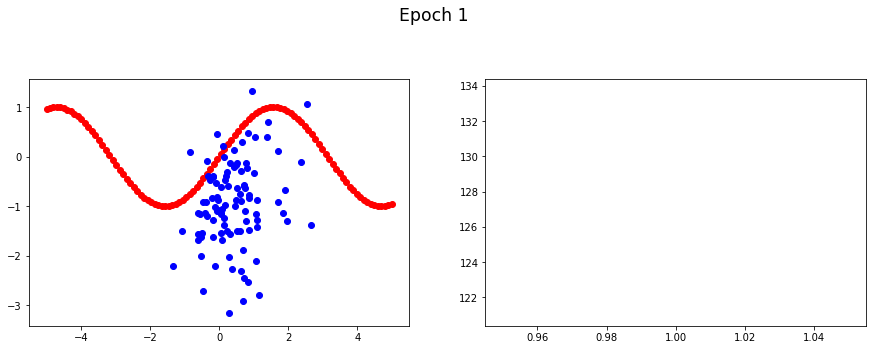

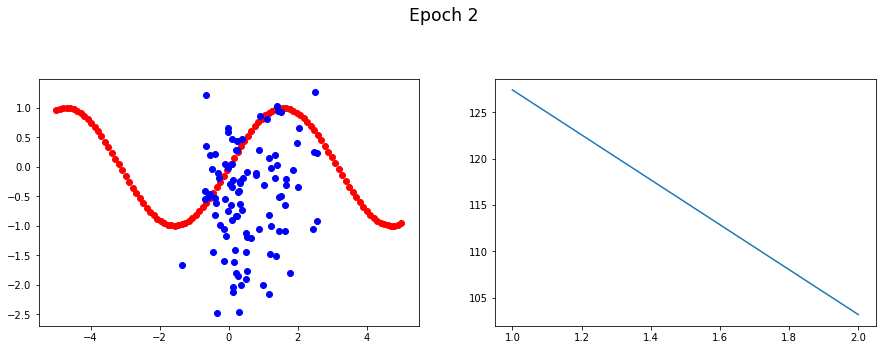

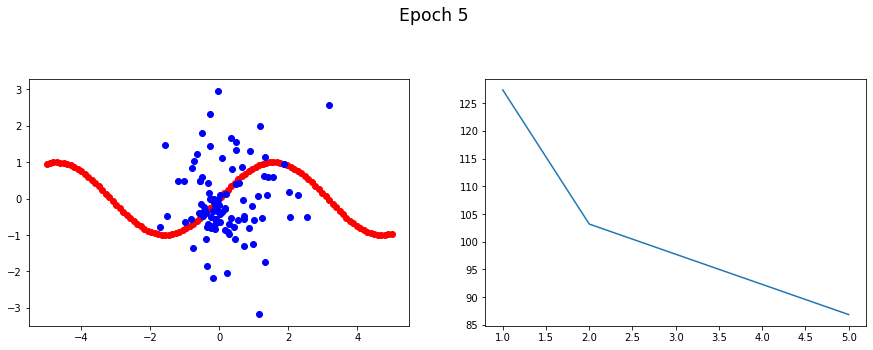

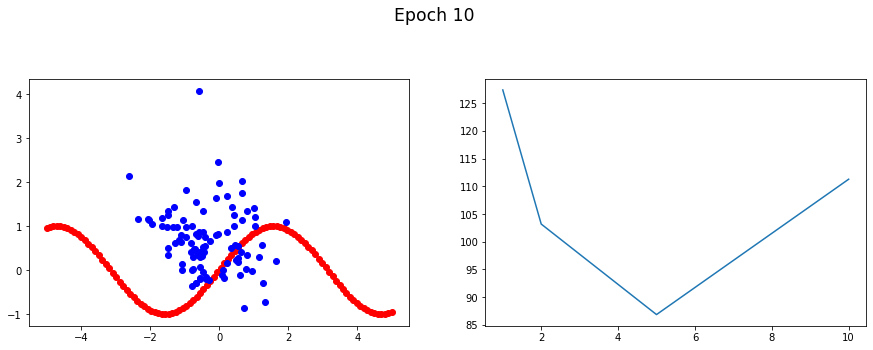

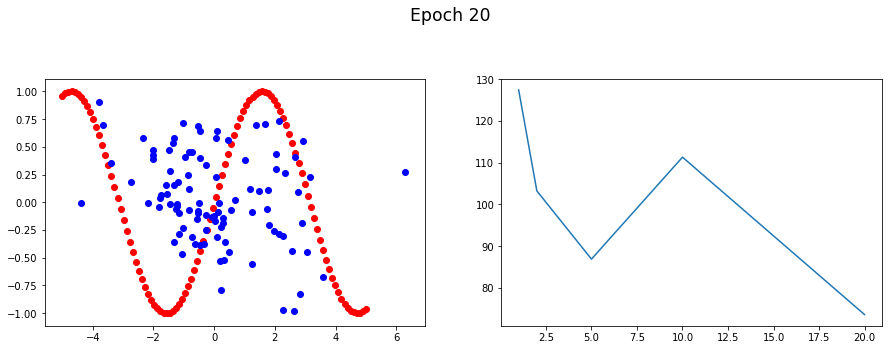

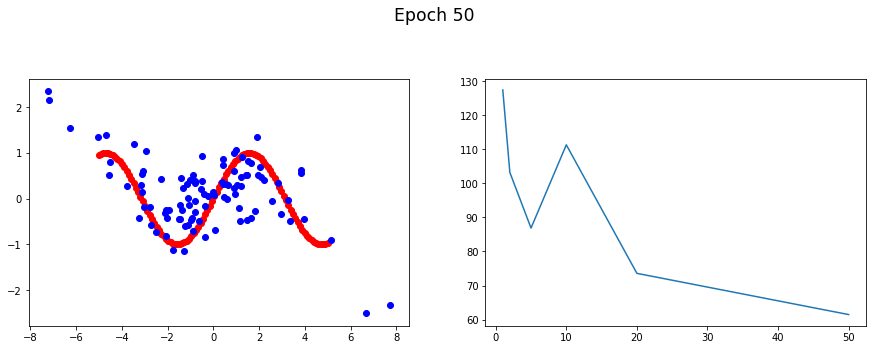

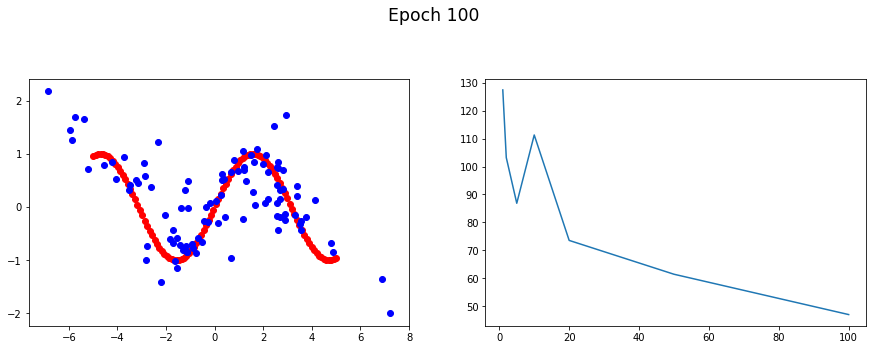

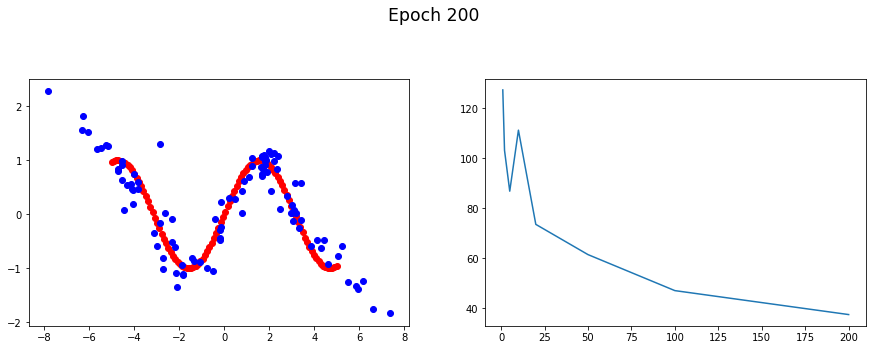

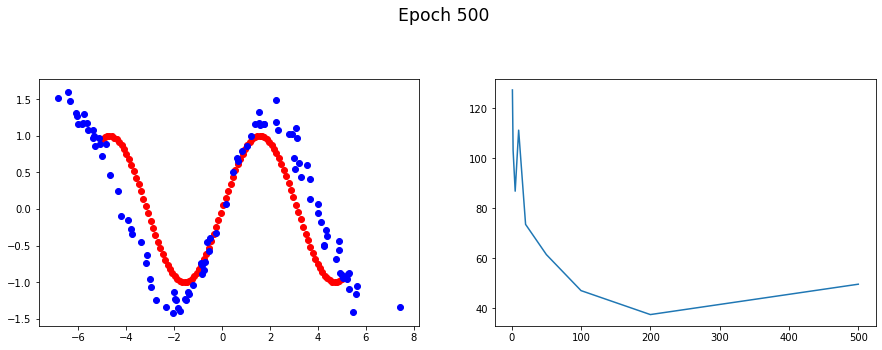

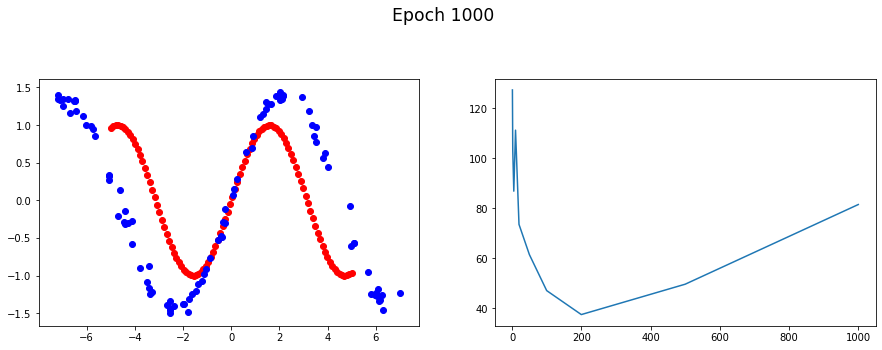

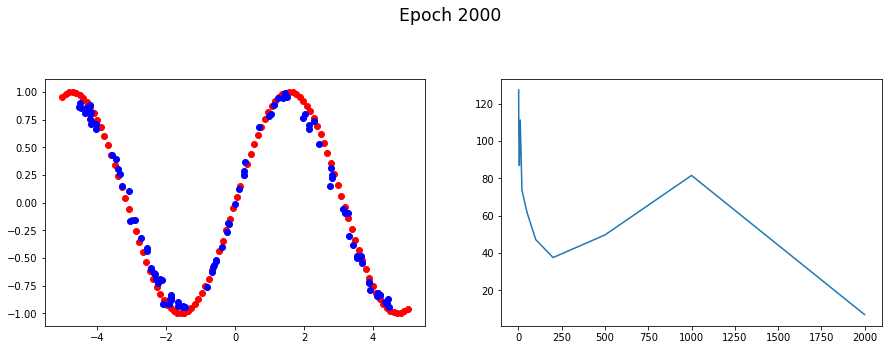

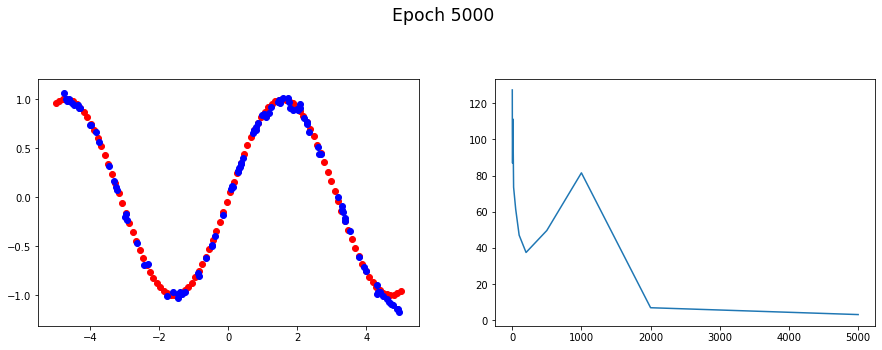

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


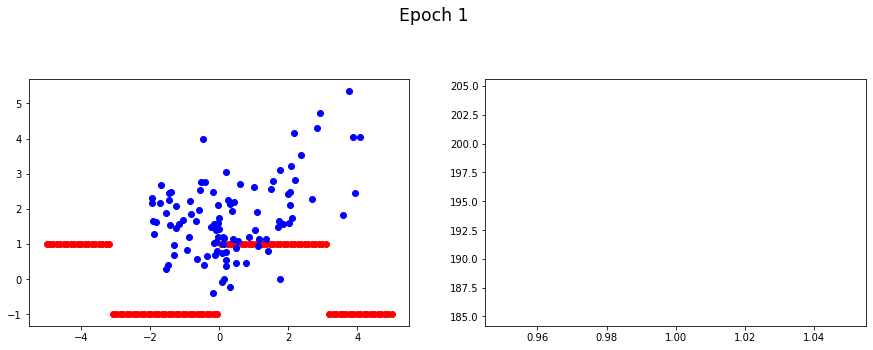

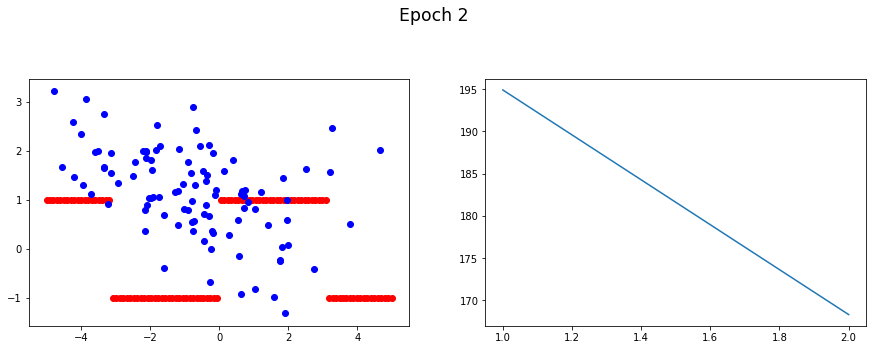

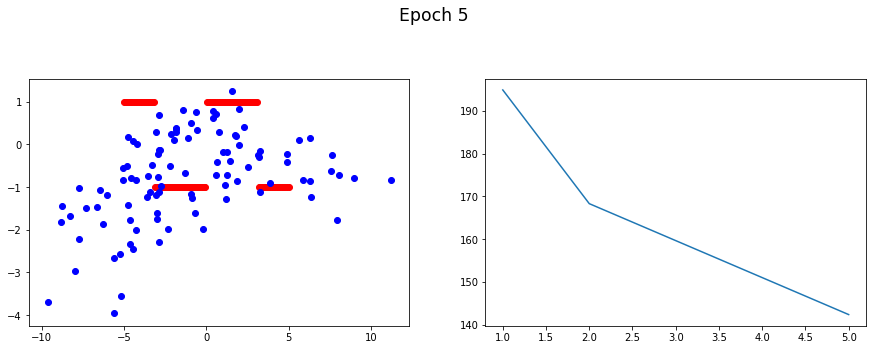

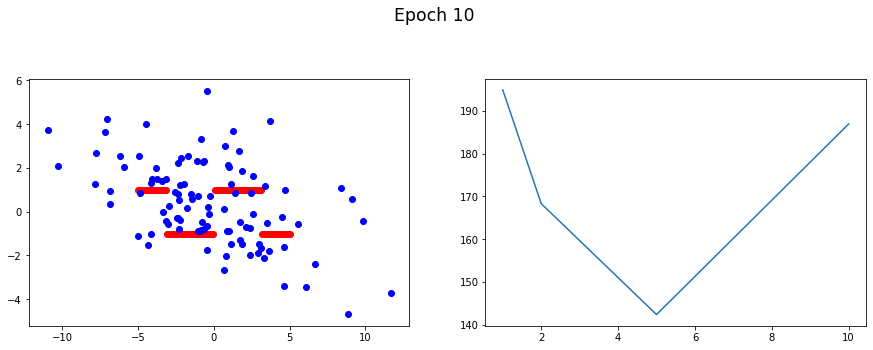

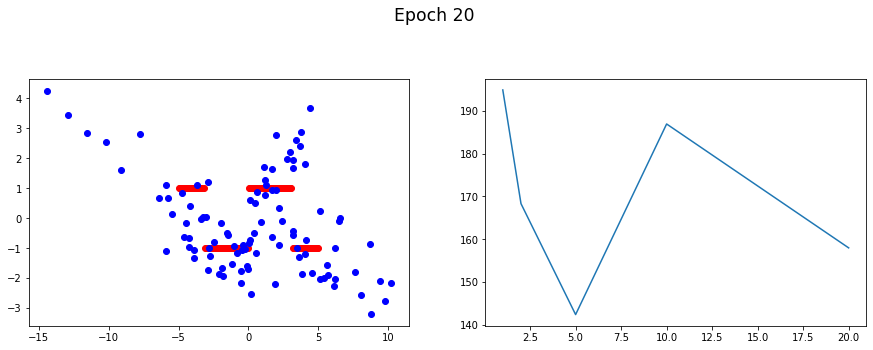

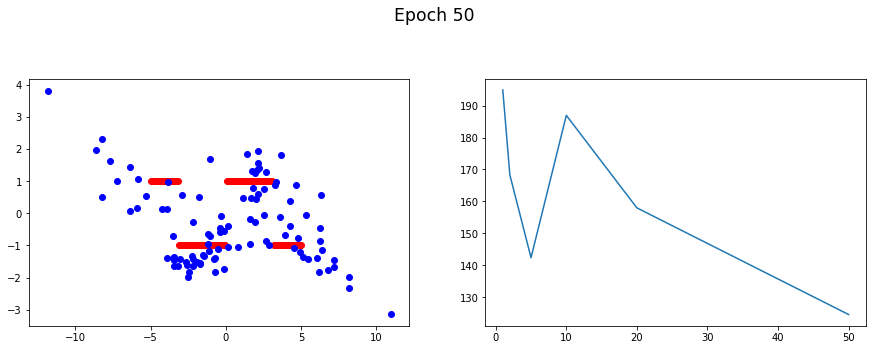

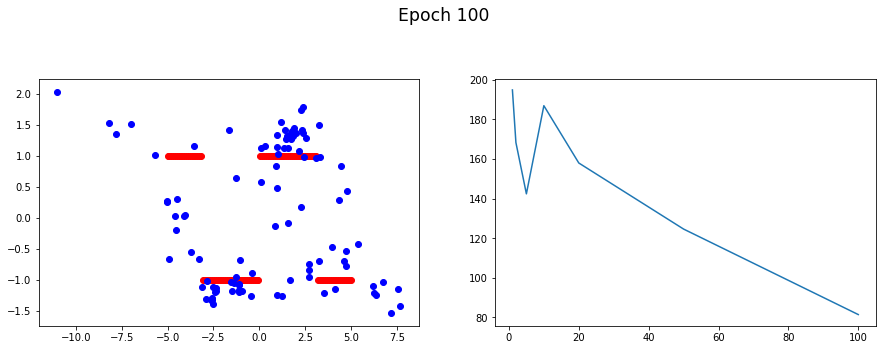

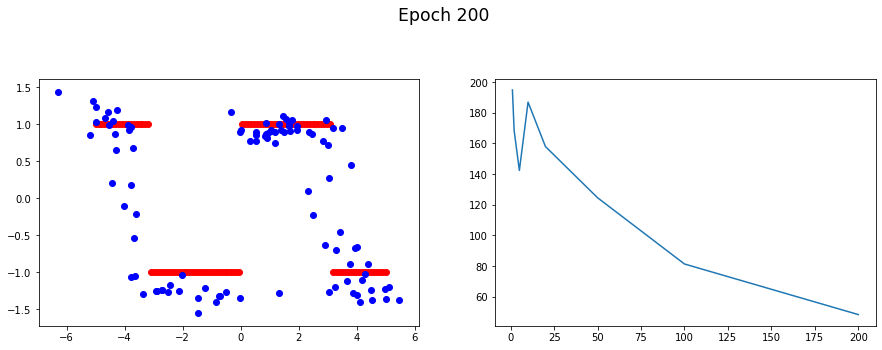

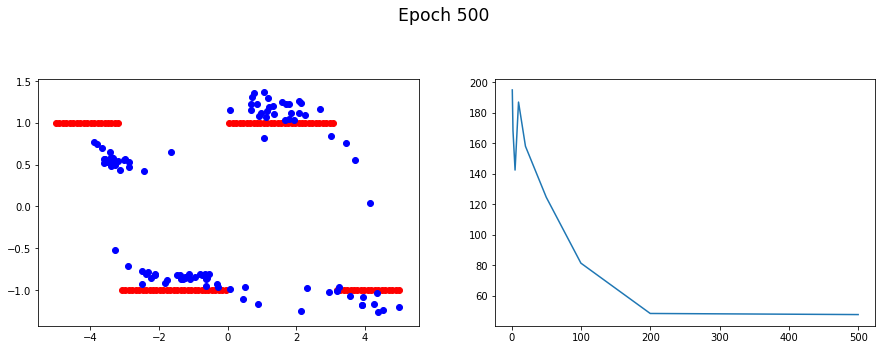

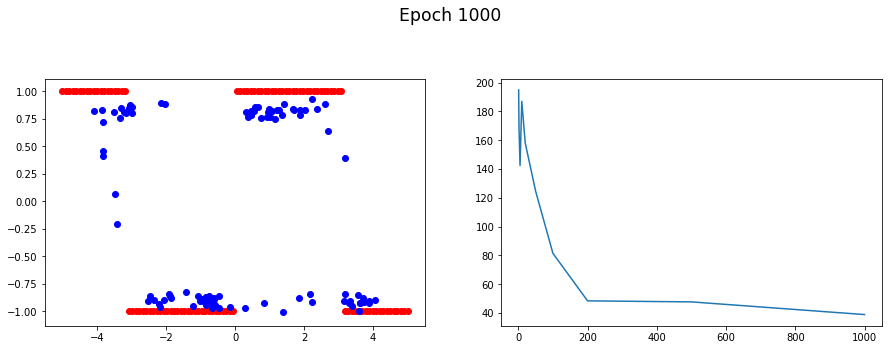

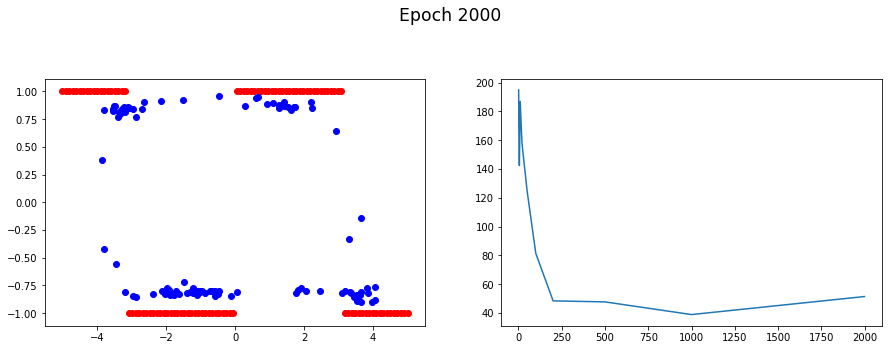

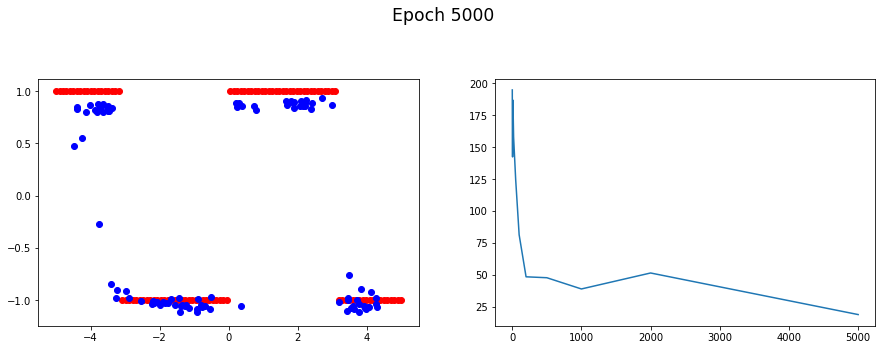

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


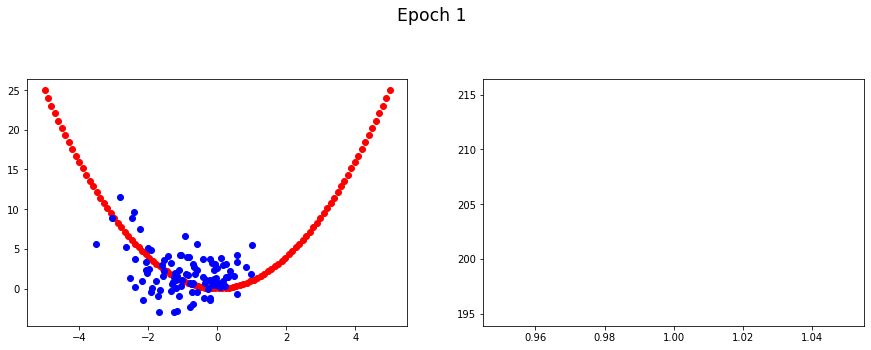

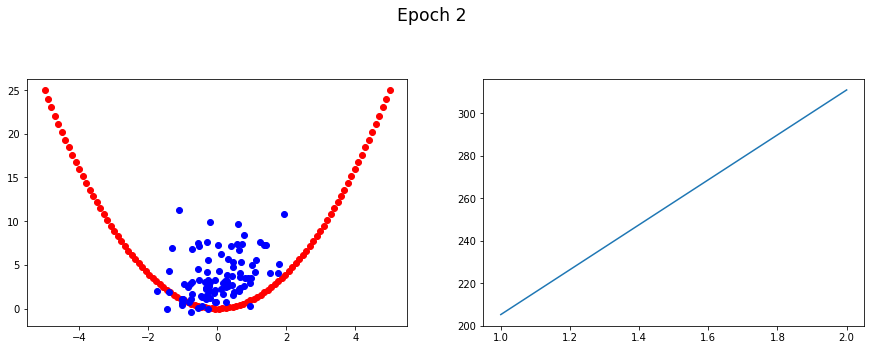

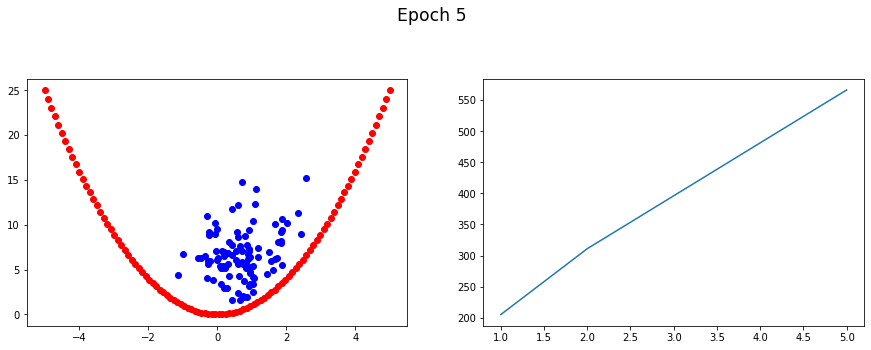

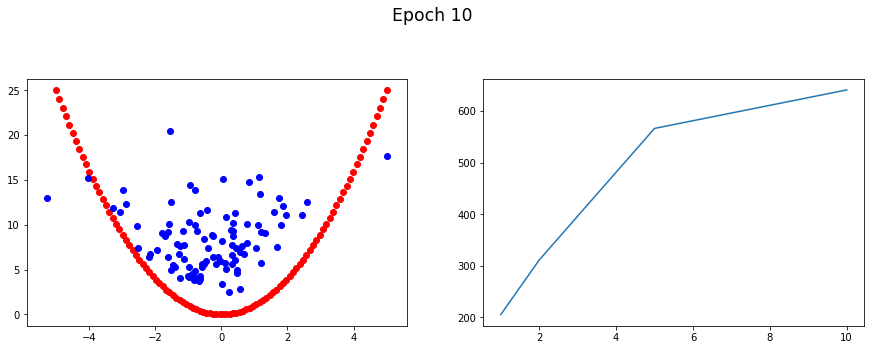

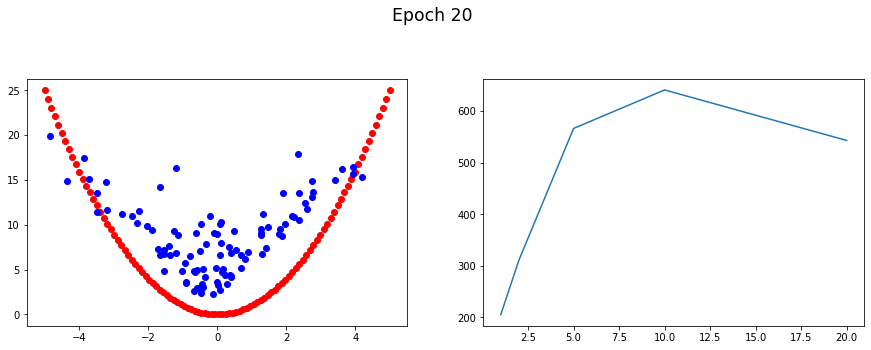

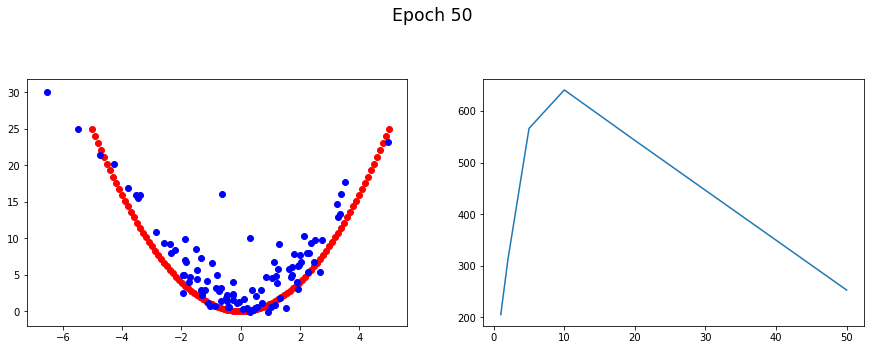

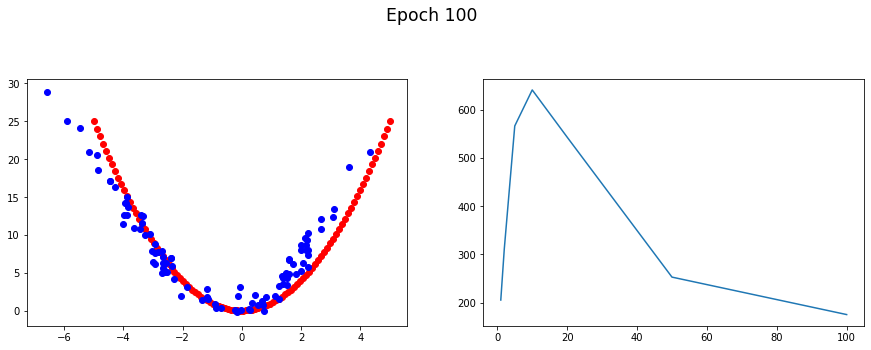

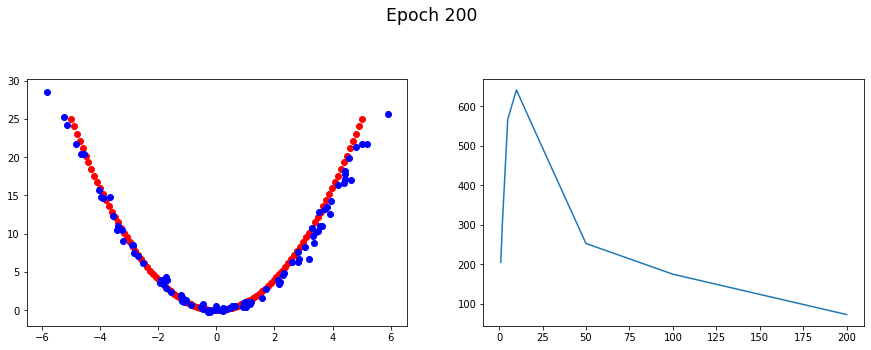

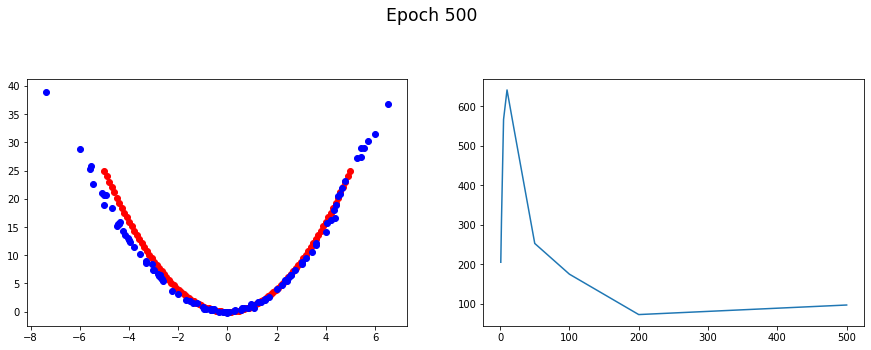

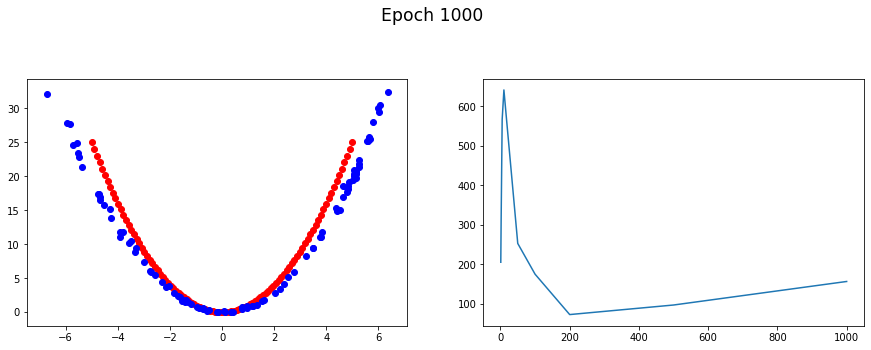

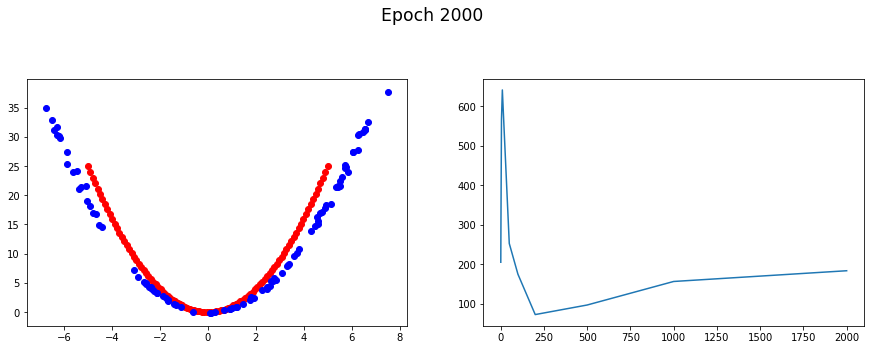

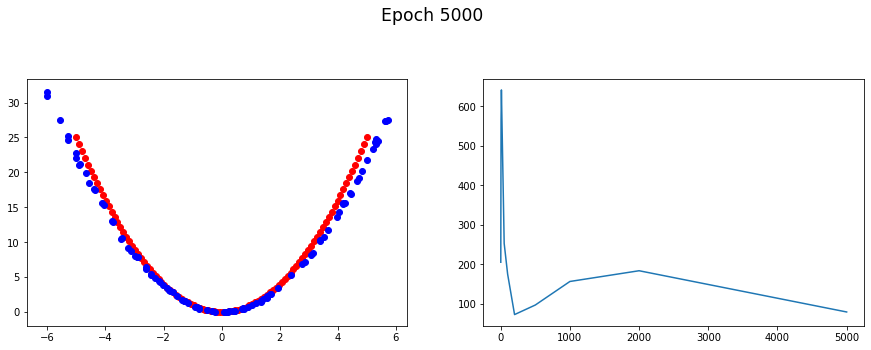

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


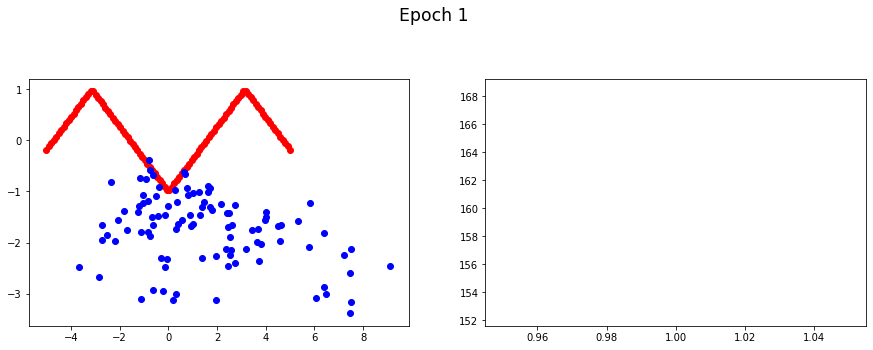

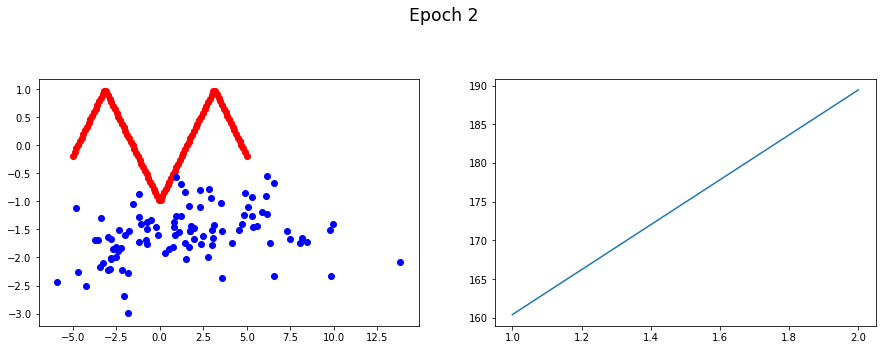

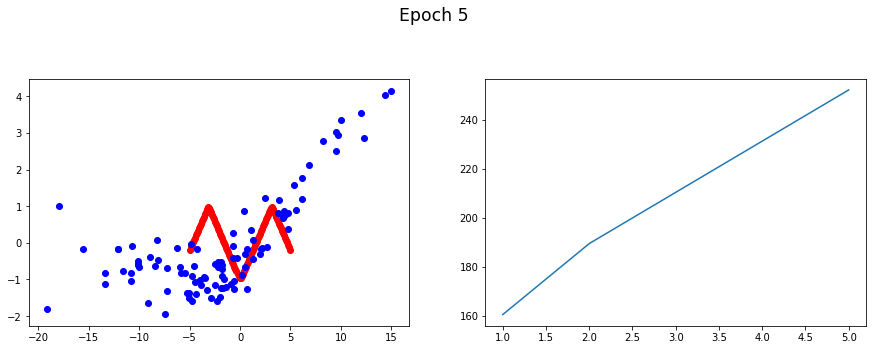

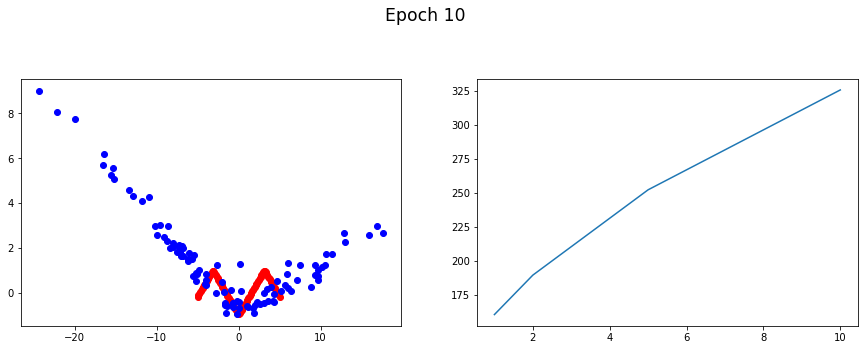

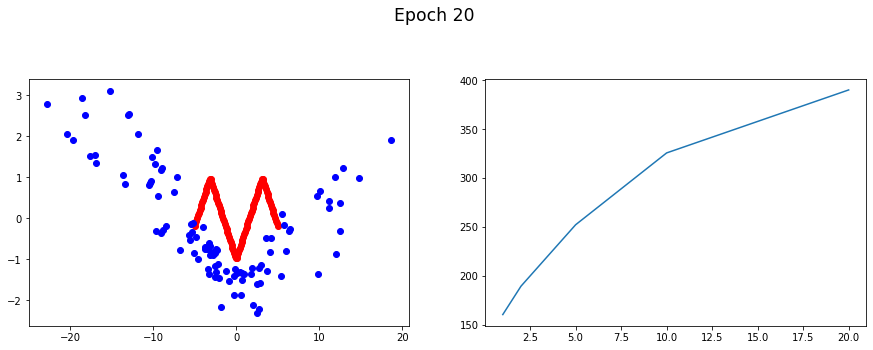

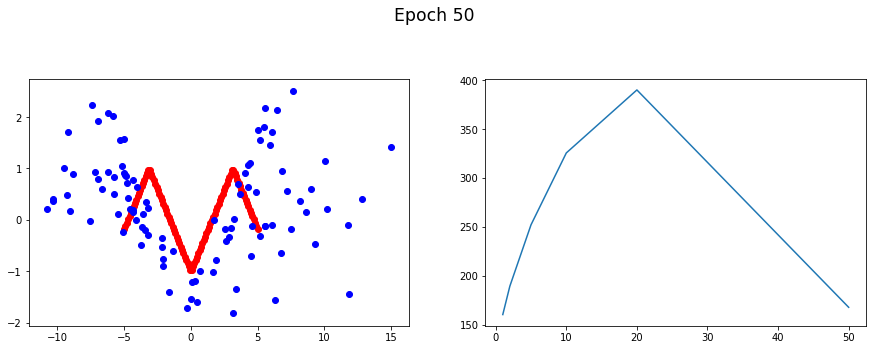

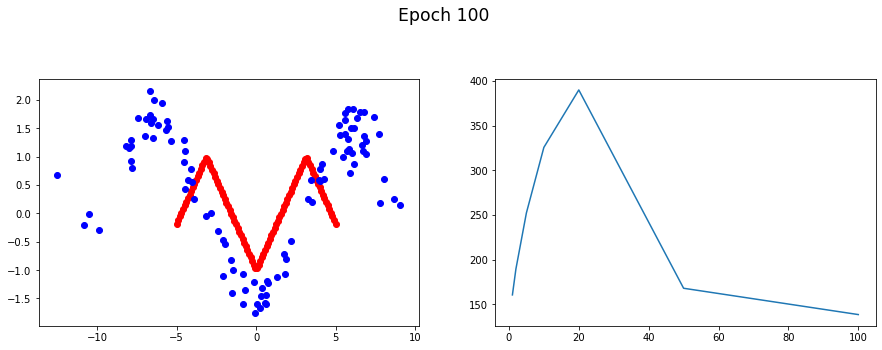

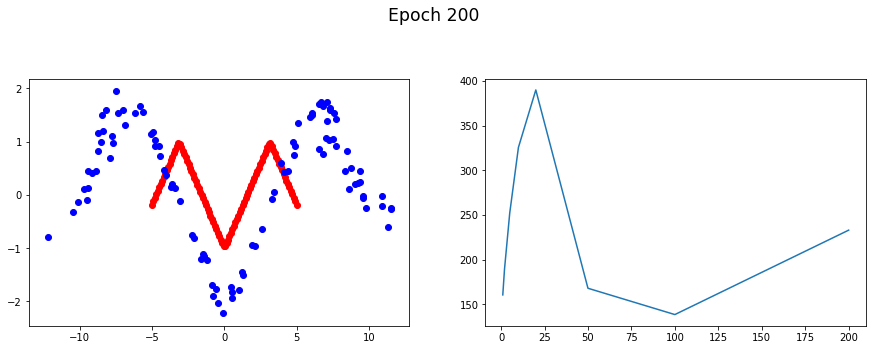

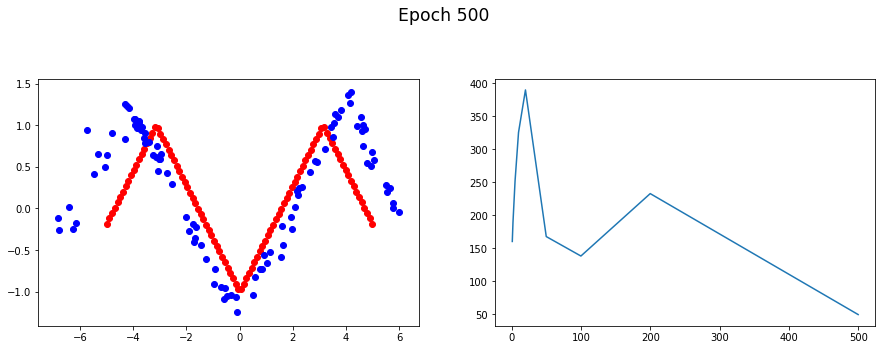

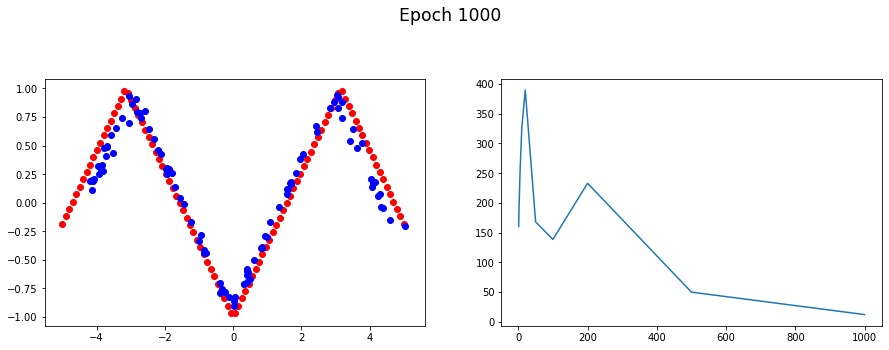

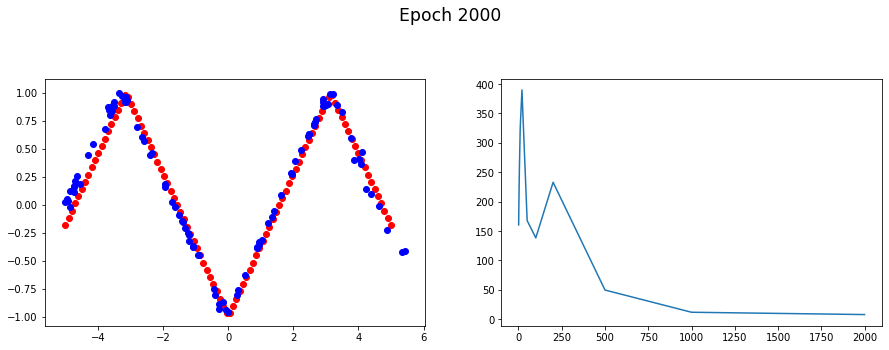

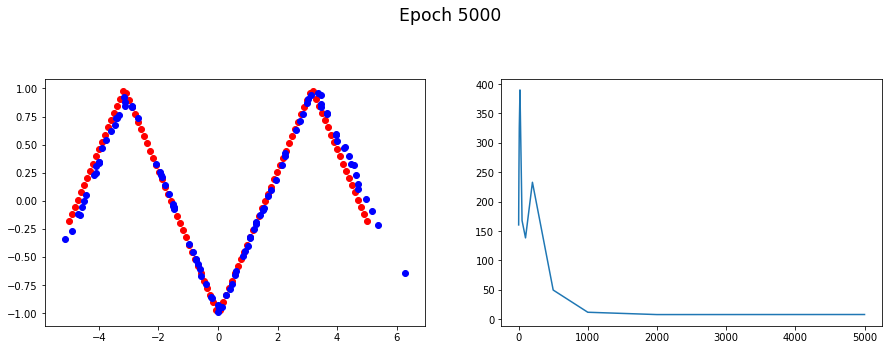

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


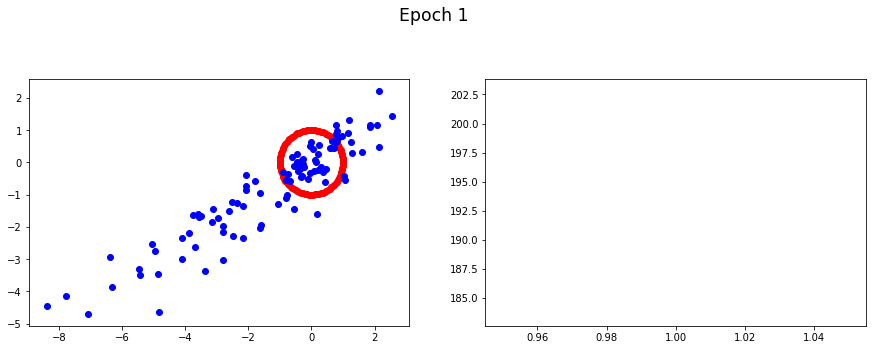

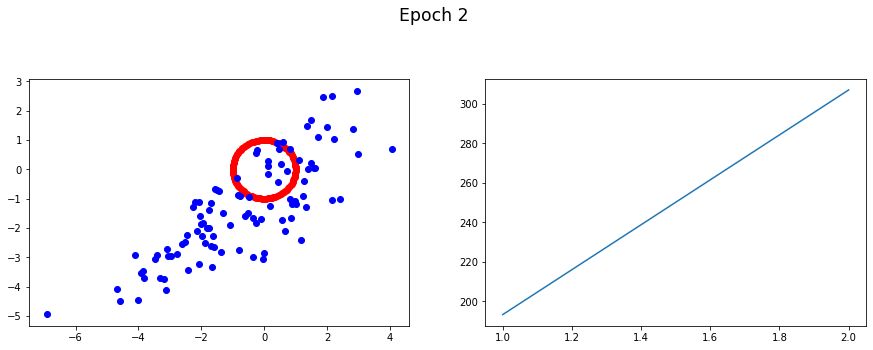

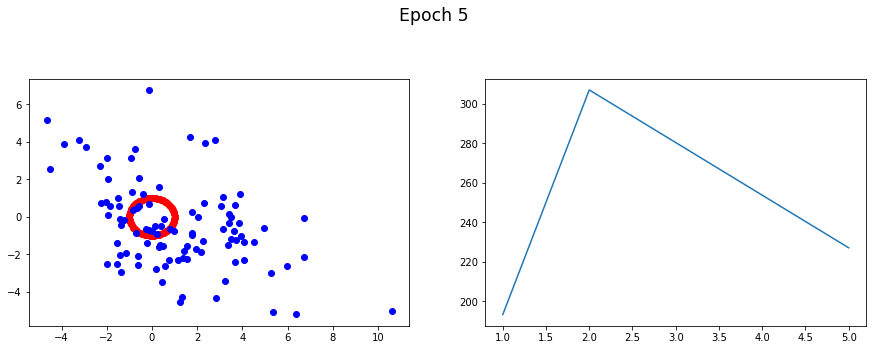

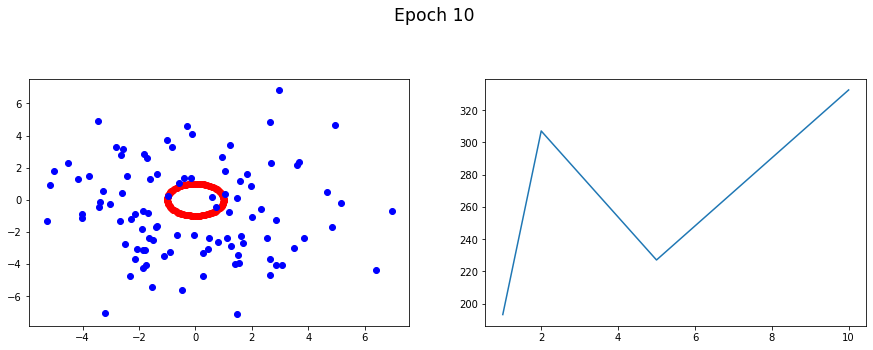

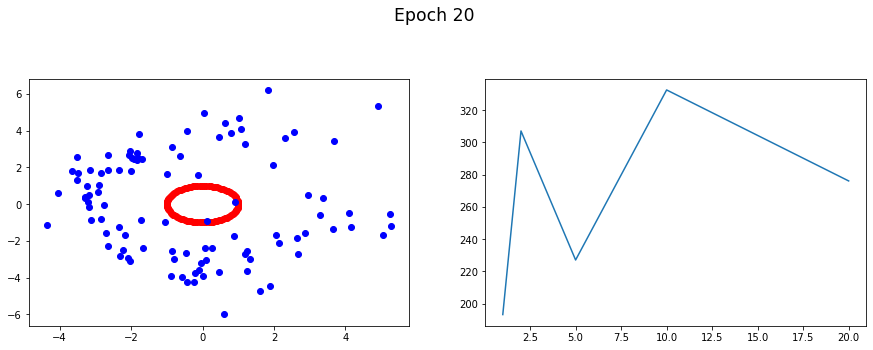

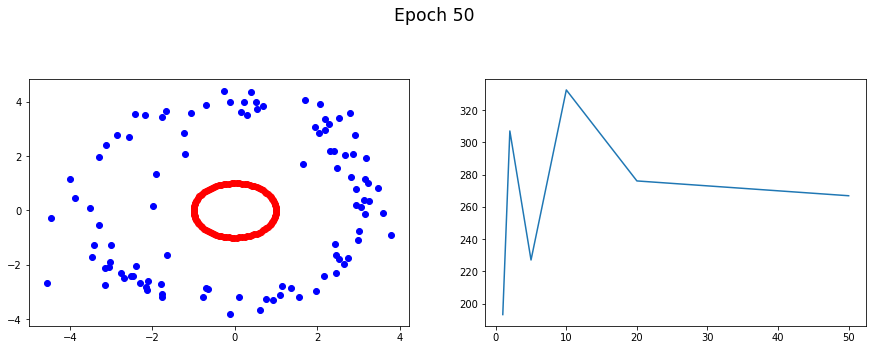

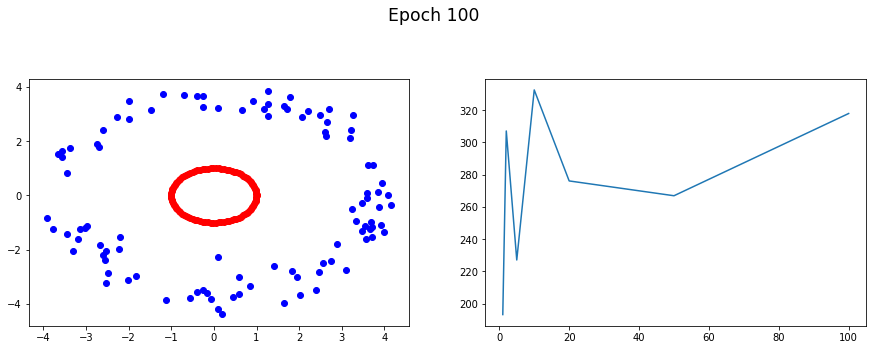

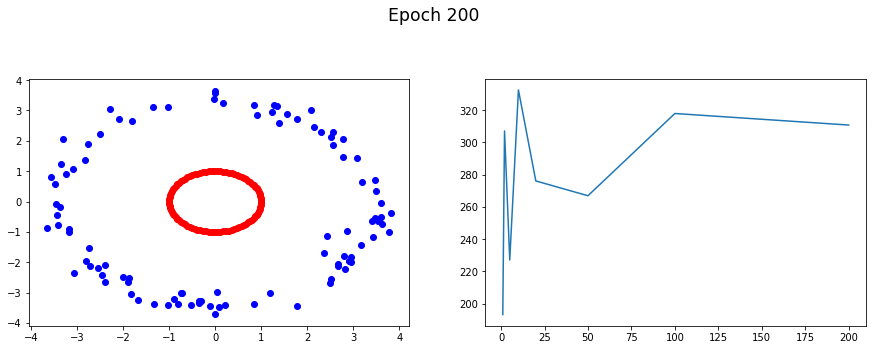

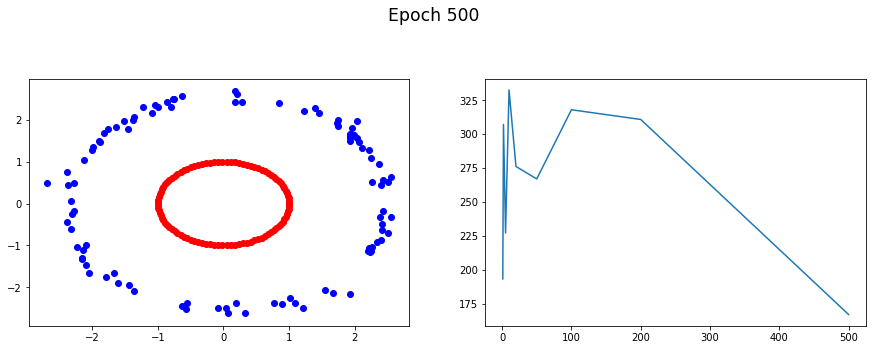

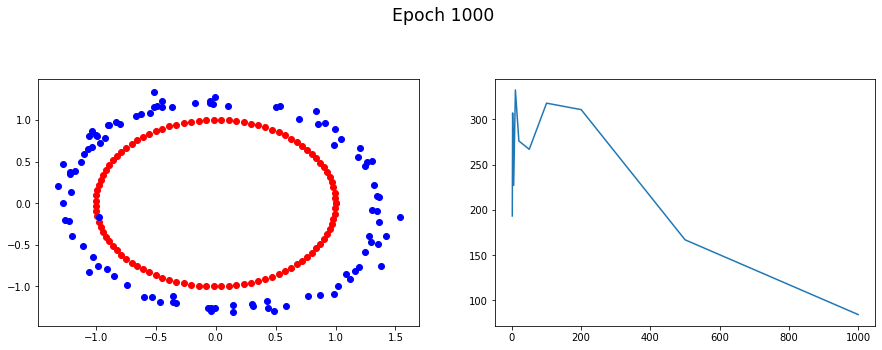

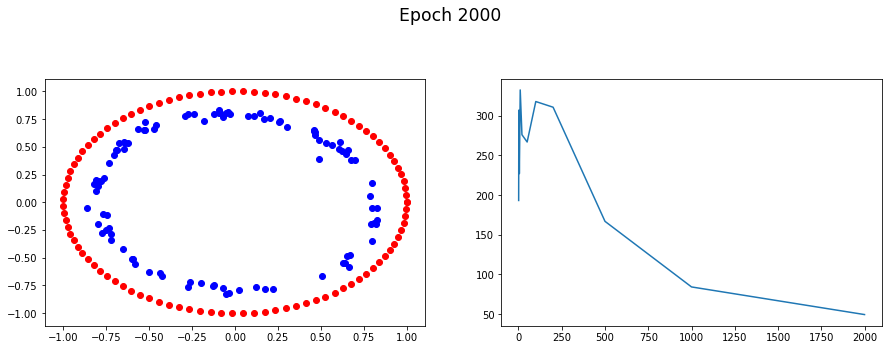

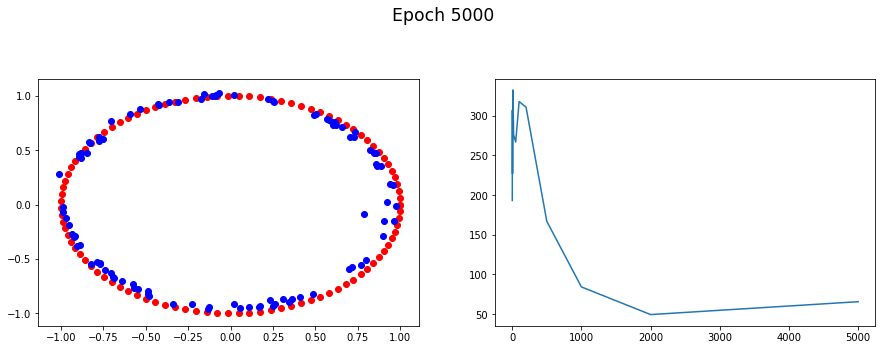

In [4]:
# Cell 4

# this does the real work of training the system.
# you should experiment with effect of changing the n_batch
def train(g_model, d_model, gan_model, latent_dim, function, eval_list, n_epochs=5000, n_batch=200):
    half_batch = int(n_batch / 2)
    epochlist = []
    errorlist = []
    for i in range(n_epochs+1):
        x_real, y_real = generate_real_1D(half_batch, function)
        x_fake, y_fake = generate_fake_1D(g_model, latent_dim, half_batch)
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        x_gan = generate_latent_points(latent_dim, n_batch)
        y_gan = np.ones((n_batch, 1))
        gan_model.train_on_batch(x_gan, y_gan)
        if i in eval_list:
            error, ax2, fig = summarize_performance(g_model, latent_dim, 100, function)
#            print("Error:", error)
            epochlist.append(i)
            errorlist.append(error)
            ax2.plot(epochlist, errorlist)
            fig.suptitle("Epoch "+str(i), fontsize = "xx-large")
            plt.show()

# in experimenting with this, the size of the latent_dim doesn't seem to matter much
latent_dim = 10
n_epochs = 5000
eval_list = [1,2,5,10,20,50,100,200,500,1000,2000,5000,10000]

for function in range (1, 6):
    # Note that we must re-create the generator and discriminator, 
    # else it will already be trained on the prior function
    # you can move the follwing 3 lines to before the 'for function ...' line
    # and see that it will start at epoch 1 with the prior function
    discriminator = create_discriminator()
    generator = create_generator(latent_dim)
    gan_model = create_GAN(generator, discriminator)
    train(generator, discriminator, gan_model, latent_dim, function, eval_list, n_epochs = n_epochs)

Please experiement with changing the range (X and Y) of the patterns. Note that the GAN learns not only the 'function' but also the range, so changing the range will mean the GAN has to start learning a new pattern. 
#### Extra credit
Create a pattern that is mostly based on a random function, but something distinctive enough that you can see if it works (e.g. random dots in a checkerboard pattern or along a line.)

# Generating Medical Images
Here we generate MR images--or at least with enough training time it will learn how to make them. To get good results will require perhaps 100 epochs, which can be more than an hour. We will settle for 'pretty good' in 5-10 minutes.

In [5]:
# Cell 5
####################################     Part 2  Make an image     ###########################################
# we will use  brain MRIs as examples to try to generate new ones



!rm -rf images
!mkdir images
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=19SuwH3NbFweutkFpa3W7tieF351yvDRM' -O ./S1-4.zip
!cd images; unzip -q "../S1-4.zip" 
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1kE8dqVUBwUuyh3ZSj5h2cPZqJMj0G6P2' -O ./S5-8.zip
!cd images; unzip -q "../S5-8.zip" 
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1f5ncqzCVNugrRppzxqKuwqz1WxETszUP' -O ./S9-12.zip
!cd images; unzip -q "../S9-12.zip" 
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1raVoqd6Egfy3C0Hw4m-gL0Aw3wNEzcKd' -O ./S13-16.zip
!cd images; unzip -q "../S13-16.zip" 
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=12yk9kJzY-8T68cvkes_YtKsBfjwk4WYk' -O ./Bet-n-dcm2nii.zip
!unzip -q ./Bet-n-dcm2nii.zip

!rm -rf tmp
!mkdir tmp

MIN_MR = 20

def rescale_5_95_percentile(image):
    dims = np.shape(image)
    image_1d = image.reshape(1, image.size)
    above = np.where(image_1d>MIN_MR, image_1d, image_1d)
    if above.size < image_1d.size/2:
        above = image_1d # avoid bad MIN_MR thresholds
    sorted_im = np.sort(above, axis = None)
    start = int(sorted_im.size / 20)  # 20 = 5%
    end = int(sorted_im.size * 19 / 20) # 95%
    start_val = sorted_im[start]
    end_val = sorted_im[end]
    
    image = np.maximum(image, start_val) # map values below the end_val to end_val
    image = np.minimum(image, end_val)   # map values above the end_val to end_val
    image = image - start_val # subtract the starting intensity

 #   print ("rescaling range " + str(newmin) + " to " + str(histo[1][index]))
    image = (np.maximum(image, 0) / image.max()) * 255.0
    return image

# creating 3 arrays: 1 for each image type.
# we will load all images of a type into the respective array
# we don't care about keeping subjects separate--we just want examples of each image type

T1 = []
T2 = []
GAD = []

for subj in fnmatch.filter(os.listdir('./images'), 'S*'):
    subj_path = os.path.join('./images', subj)
    print (subj_path)
    series = os.listdir(subj_path)
    series = ['T1', 'T2', 'GAD']
    for ser in series:
        cmd = "./dcm2nii -o tmp %s" % (os.path.join (subj_path, ser))
        os.system(cmd)
        f = fnmatch.filter(os.listdir('./tmp'), '*.nii.gz')
        # now read the nifti file just made and add to the numpy array for the 3 types of images
        
        nii_file = os.path.join('./tmp', f[0])   # this call returns an array, but since we keep deleting, there is only 1
        nifti = nib.load(nii_file)
        nif_header = nifti.header
        img = nifti.get_fdata()
        img = rescale_5_95_percentile(img)# now scale the intensity for each image        
        img = img.astype(np.uint8)  # then convert to 8 bits
        img = np.rot90(img, k=1)    # now must rotate 90 degrees cuz nibabel loads them rotated
        img = img[::2, ::2, :]      # and also cut xdim and ydim in half due to memory limits
        dims = np.shape(img)        # then append them on to the end of the array
        zd = dims[2]
        for z in range(int(zd/4), int(zd * 4 / 5)):  # elim slices at top and bottom
            if 'T1' in ser:
                T1.append(img[:,:,z])
            if 'T2' in ser:
                T2.append(img[:,:,z])
            if 'GAD' in ser:
                GAD.append(img[:,:,z])
            
        cmd = "rm ./tmp/%s" % (f[0])  # delete it when done
        os.system(cmd)

XDim = YDim = 128   #128 works   192 or 256 doesn't
XDim4 = int(XDim / 4)
if (XDim != dims[0]):
    print ("Error: mismatched dimensions: need 128x128 images to work")

--2019-11-29 14:30:13--  https://docs.google.com/uc?export=download&id=19SuwH3NbFweutkFpa3W7tieF351yvDRM
Resolving docs.google.com (docs.google.com)... 108.177.125.113, 108.177.125.102, 108.177.125.138, ...
Connecting to docs.google.com (docs.google.com)|108.177.125.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bddu58ce0b7m0fsuqncj19ns77btve61/1575036000000/16160187475894979440/*/19SuwH3NbFweutkFpa3W7tieF351yvDRM?e=download [following]
--2019-11-29 14:30:21--  https://doc-0s-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bddu58ce0b7m0fsuqncj19ns77btve61/1575036000000/16160187475894979440/*/19SuwH3NbFweutkFpa3W7tieF351yvDRM?e=download
Resolving doc-0s-60-docs.googleusercontent.com (doc-0s-60-docs.googleusercontent.com)... 74.125.204.132, 2404:6800:4008:c04::84
Connecting to doc-0s-60-docs.googleusercontent.com (doc-0s-

# Middle Section: Creating MR Images
In this part, we train a GAN to generate images that are similar to our training set, which are T1-weighted images of the head. Just like with 1D, we have a function to load a random sampling of real images, a generator function that makes images that are supposed to be like the real images, and a discriminator that is trying to tell the difference between the real and generated images.
Feel free to switch your data to the T2 or post-contrast MRIs. The GAN will learn whatever you feed to it!

In [0]:
# Cell 6 . functions to load groups of real images
def load_real_samples():
    # plot images from the training dataset
    # switch this to T2 or GAD if you prefer
    X = T2
#    print (len(X))
#    print (X[0].shape)
    for i in range(4 * 4):
        pyplot.subplot(4, 4, 1 + i)        # define subplot
        pyplot.axis('off')                 # turn off axis
        pyplot.imshow(X[i], cmap='gray')   # plot raw pixel data
    pyplot.show()

    X = expand_dims(X, axis=-1)	# expand to 3d, e.g. add channels
    X = X.astype('float32')	# convert from ints to floats
    X = (X - 127.5) / 127.5 	# scale from [0,255] to [-1,1]
    return X

# select real samples
def generate_real_samples(dataset, n_samples):
	ix = randint(0, dataset.shape[0], n_samples)	# choose random instances
	X = dataset[ix]	            # select images
	y = ones((n_samples, 1))	# generate class labels--1 for real
	return X, y

In [0]:
# Cell 7   define the standalone discriminator model
def create_discriminator(in_shape=(XDim, YDim,1)):
	model = Sequential()
	# downsample to 32x32
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 16x16
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def create_generator(latent_dim):
	model = Sequential()
	# foundation for quarter on each side image
	n_nodes = 128 * XDim4 * XDim4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((XDim4, XDim4, 128)))
	# upsample
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to original res
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# generate
	model.add(Conv2D(1, (XDim4,XDim4), activation='tanh', padding='same'))
	return model

# define the combined generator and discriminator model, for updating the generator
def create_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [0]:
# Cell 8    generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n_samples, 1))
	return X, y



In [0]:
# Cell 9  plot images
def plot_n_save(examples, n, cnt):
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray')

    fig = pyplot.gcf()
    fig.set_size_inches(16, 16)
    name = 'GAN_ep_%3d.png' % (cnt)
    fig.savefig(name)
    pyplot.show()

In [0]:
# Cell 10
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=25, n_batch=64): # n_batch was 128 larger # batches means smaller batch size
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
	# manually enumerate epochs
    for i in range(n_epochs):
		# enumerate batches over the training set
        for j in range(bat_per_epo):
			# get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)

			# summarize loss on this batch
        if i+1 in [1,2,5,10,20,50,100,200,500,1000,2000,5000]:
            print('Epoch : %d, Losses: discrim real=%.3f, discrim fake=%.3f gan=%.3f' % (i+1, d_loss1, d_loss2, g_loss))
            plot_n_save (X_fake, 4, i)

	# save the generator model
    g_model.save('generator.h5')
    return


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


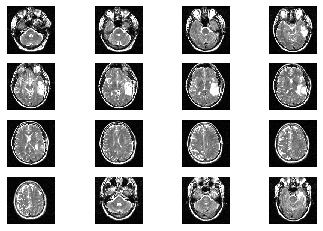

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch : 1, Losses: discrim real=0.079, discrim fake=0.457 gan=1.225


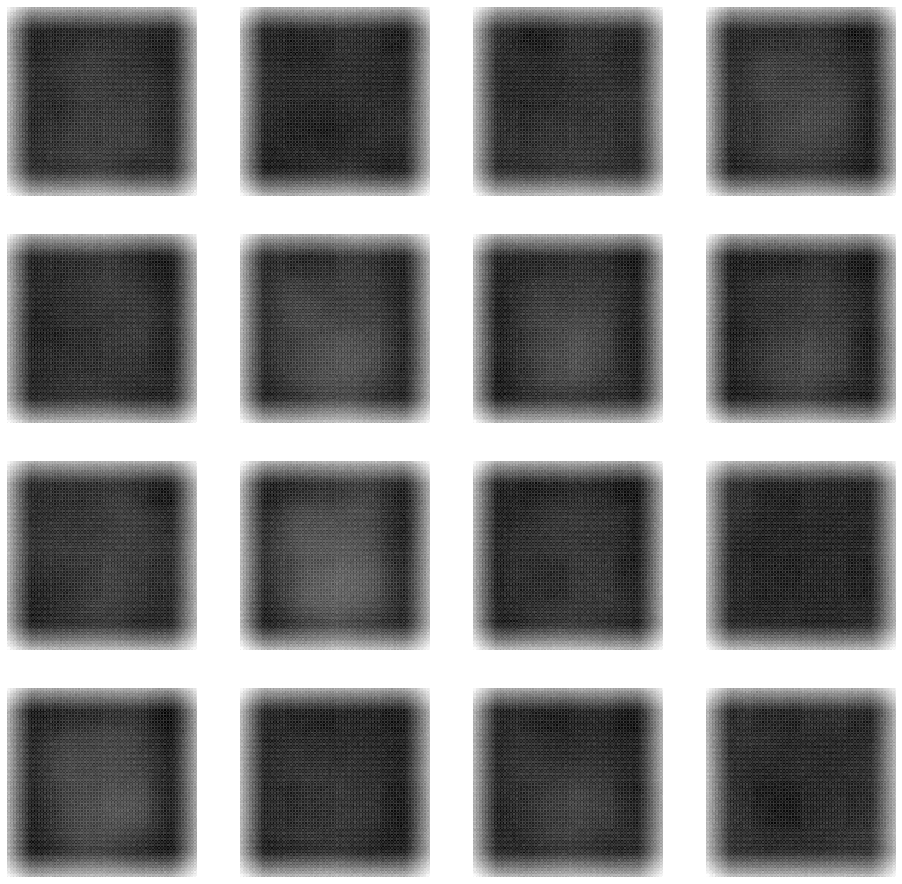

Epoch : 2, Losses: discrim real=0.041, discrim fake=0.882 gan=0.778


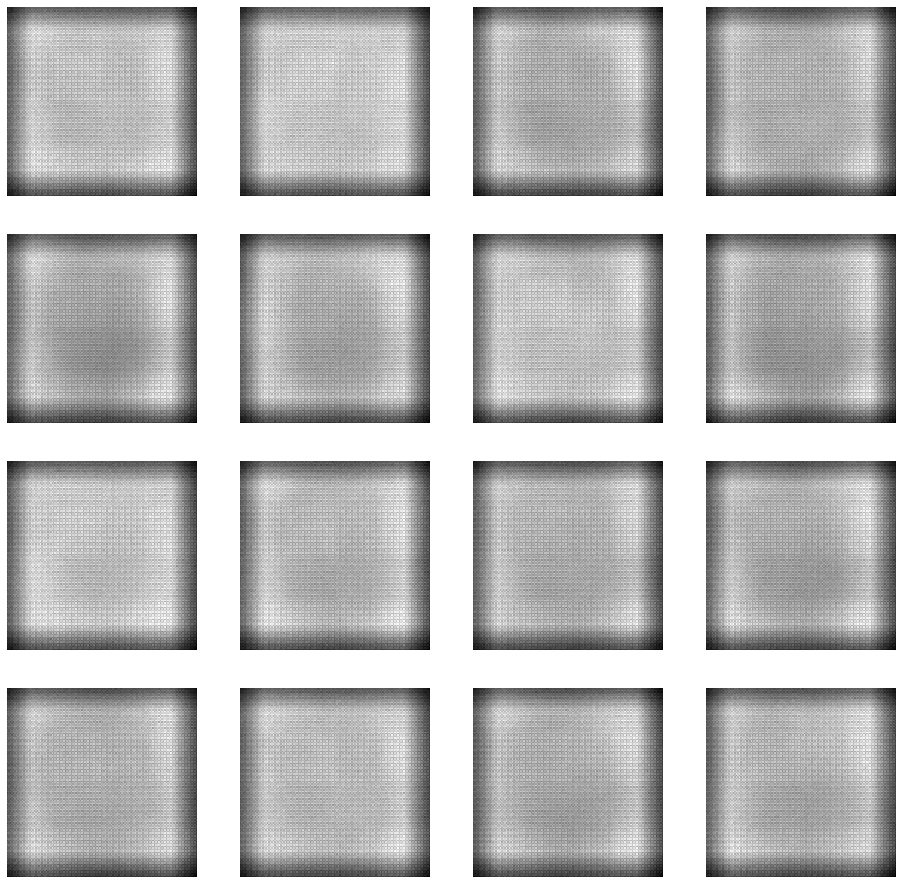

Epoch : 5, Losses: discrim real=0.006, discrim fake=0.236 gan=1.697


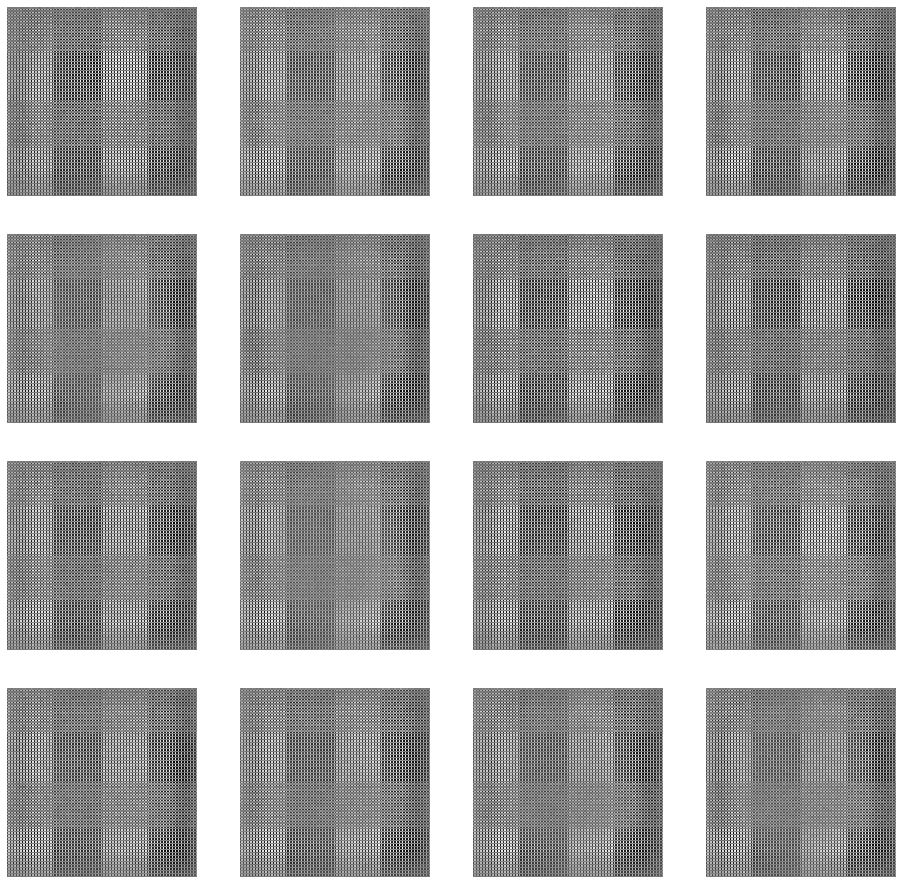

Epoch : 10, Losses: discrim real=0.560, discrim fake=0.337 gan=2.453


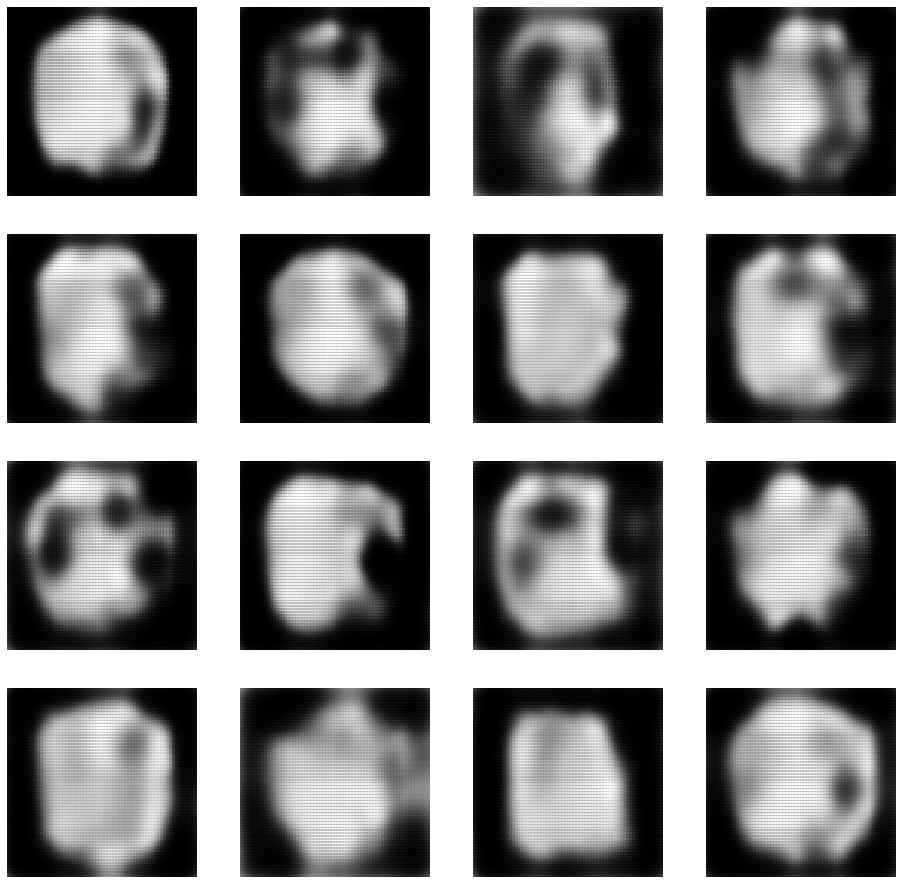

Epoch : 20, Losses: discrim real=0.140, discrim fake=0.123 gan=4.656


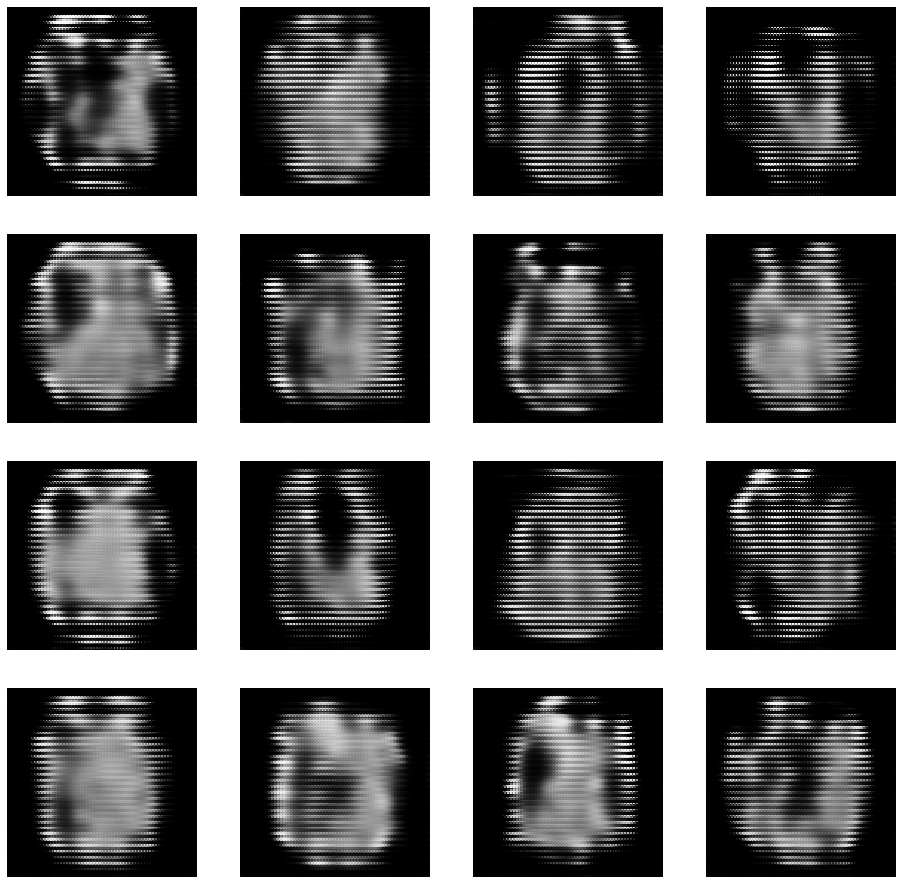

Epoch : 50, Losses: discrim real=0.385, discrim fake=0.324 gan=1.498


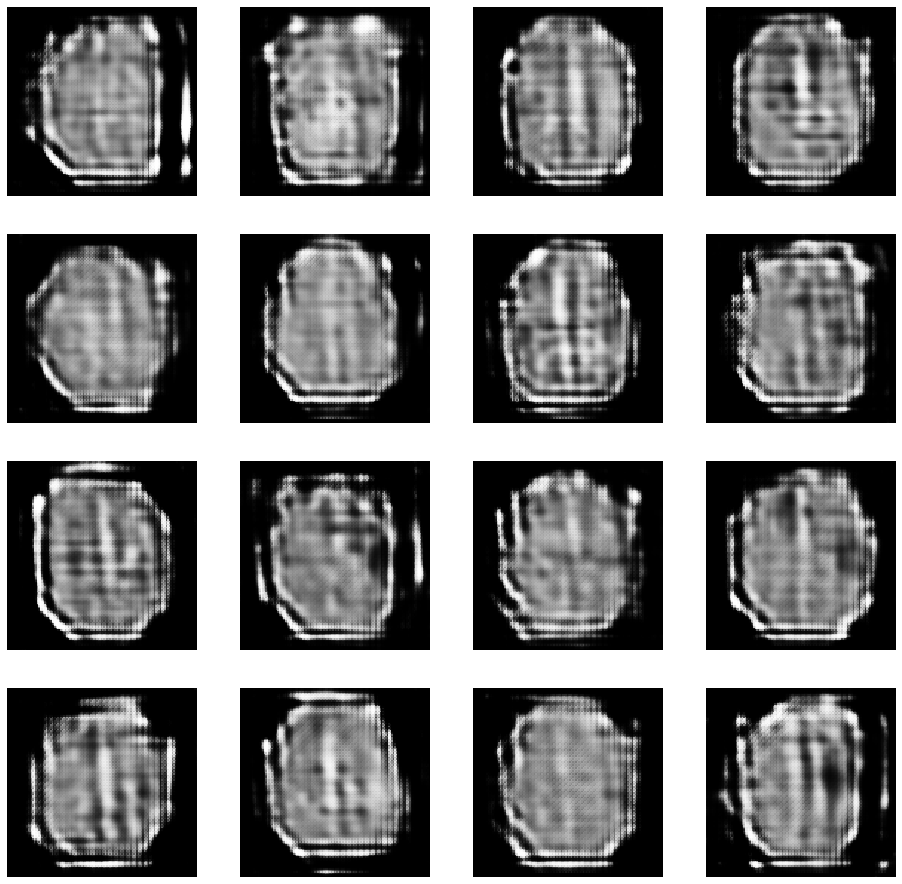

Epoch : 100, Losses: discrim real=0.415, discrim fake=0.475 gan=1.594


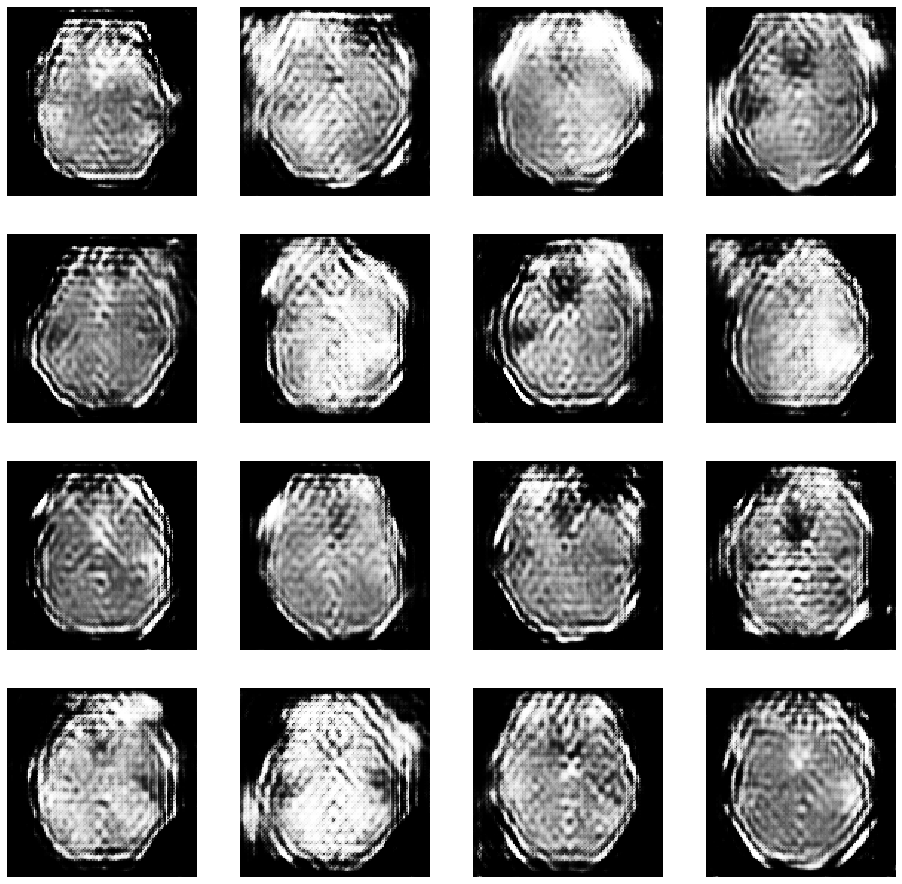

In [11]:
# Cell 11
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = create_discriminator()
# create the generator
generator = create_generator(latent_dim)
# create the gan
gan_model = create_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs = 100, n_batch=32)

# Final Section: Style Transfer using Pix2Pix
###This notebook comes almost entirely from the [Tensorflow Pix2Pix Tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix) with only minor changes. The dataset was created from the [Brain-Development.org IXI Dataset](https://brain-development.org/ixi-dataset/).

## For this, we will access tensorboard, and that is incompatible with the version of tensorflow used above.  Therefore, please click the link below, which will load the pix_2_pix notebook.

https://colab.research.google.com/github/slowvak/AI-Deep-Learning-Lab/blob/master/RSNA_pix_2_pix.ipynb